# Import data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install seaborn --user
# !pip install image-classifiers
# !pip install tensorflow==1.13.1
# !pip install tensorflow-gpu==1.13.1
# !pip install keras-vis
# !pip install --upgrade scikit-image

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import pandas as pd
import random
import seaborn as sns
import vis ## keras-vis

from keras import optimizers, callbacks, Model
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn import datasets, metrics
from vis.utils import utils
from vis.visualization import visualize_cam, visualize_saliency
from keras import activations

print("keras      {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))
%matplotlib inline

Using TensorFlow backend.


keras      2.2.4
tensorflow 1.13.1


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15469882266557711615
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5961603255428443946
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7377221973334063154
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15368694061662139506
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6618080865048161598
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:4"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2393316926712473037
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:5"
device_t

# Classificando imagens em Landmarks

## Lendo o conjunto de dados

In [5]:
seed = random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = '/home/ubuntu/landmarks/landmarks'
target_size = (224, 224)
input_shape = (224, 224, 3)

sample_generator = sample_datagen.flow_from_directory(base_path + '/train',
                                                      target_size=target_size,
                                                      batch_size=32,
                                                      class_mode="sparse",
                                                      seed = seed)

sample_test_generator = sample_datagen.flow_from_directory(base_path + "/test",
                                                           target_size = target_size,
                                                           batch_size = 32,
                                                           class_mode = "categorical",
                                                           seed = seed)

classes = [x for x in sample_generator.class_indices.keys()]
total_classes = np.max(sample_generator.labels) + 1

x_sample, y_sample = sample_generator.next()
x_sample_test, y_sample_test = sample_test_generator.next()
print('\n')
print('Showing y sample:', y_sample)
print('\n')
print('samples in train: %i' % sample_generator.labels.shape,
      'samples in test: %i' % sample_test_generator.labels.shape,
      'features: %s' % str(x_sample.shape[1:]),
      'classes: %i' % total_classes,
      sep='\n', end='\n\n')

print('shape:', x_sample.shape, x_sample_test.shape)
print(sample_generator.class_indices)
print(classes)

Found 61052 images belonging to 100 classes.
Found 15264 images belonging to 100 classes.


Showing y sample: [86. 16. 58. 67. 10. 13. 28. 90. 69. 16. 66. 43. 45. 91. 28. 19. 32. 94.
 27. 26. 49. 13. 70. 53. 51. 77. 83. 52. 96. 84. 35. 91.]


samples in train: 61052
samples in test: 15264
features: (224, 224, 3)
classes: 100

shape: (32, 224, 224, 3) (32, 224, 224, 3)
{'100631': 0, '101399': 1, '10419': 2, '105337': 3, '107164': 4, '107750': 5, '107917': 6, '108327': 7, '109169': 8, '110398': 9, '111311': 10, '113145': 11, '113750': 12, '11544': 13, '115821': 14, '120885': 15, '121547': 16, '126721': 17, '13755': 18, '142343': 19, '142644': 20, '142809': 21, '143710': 22, '145015': 23, '145310': 24, '146250': 25, '146497': 26, '147828': 27, '147897': 28, '152827': 29, '15445': 30, '158844': 31, '160944': 32, '162833': 33, '165596': 34, '171150': 35, '171435': 36, '173511': 37, '176956': 38, '177194': 39, '177305': 40, '178519': 41, '180759': 42, '180901': 43, '181631': 44, '182908': 45

## Lendo as 32 primeiras amostras no conjunto de treinamento

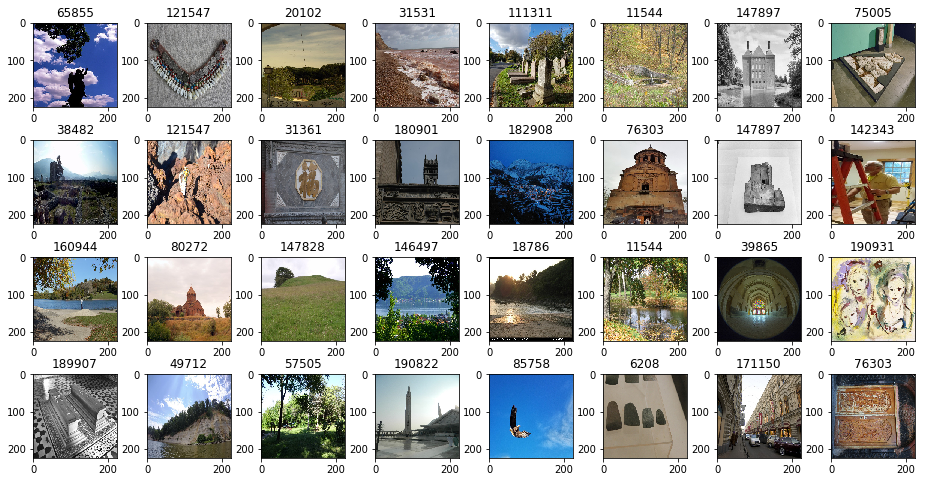

In [6]:
plt.figure(figsize=(16, 8))
for i in range(4 * 8):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

## Visualizando frequência das classes no conjunto

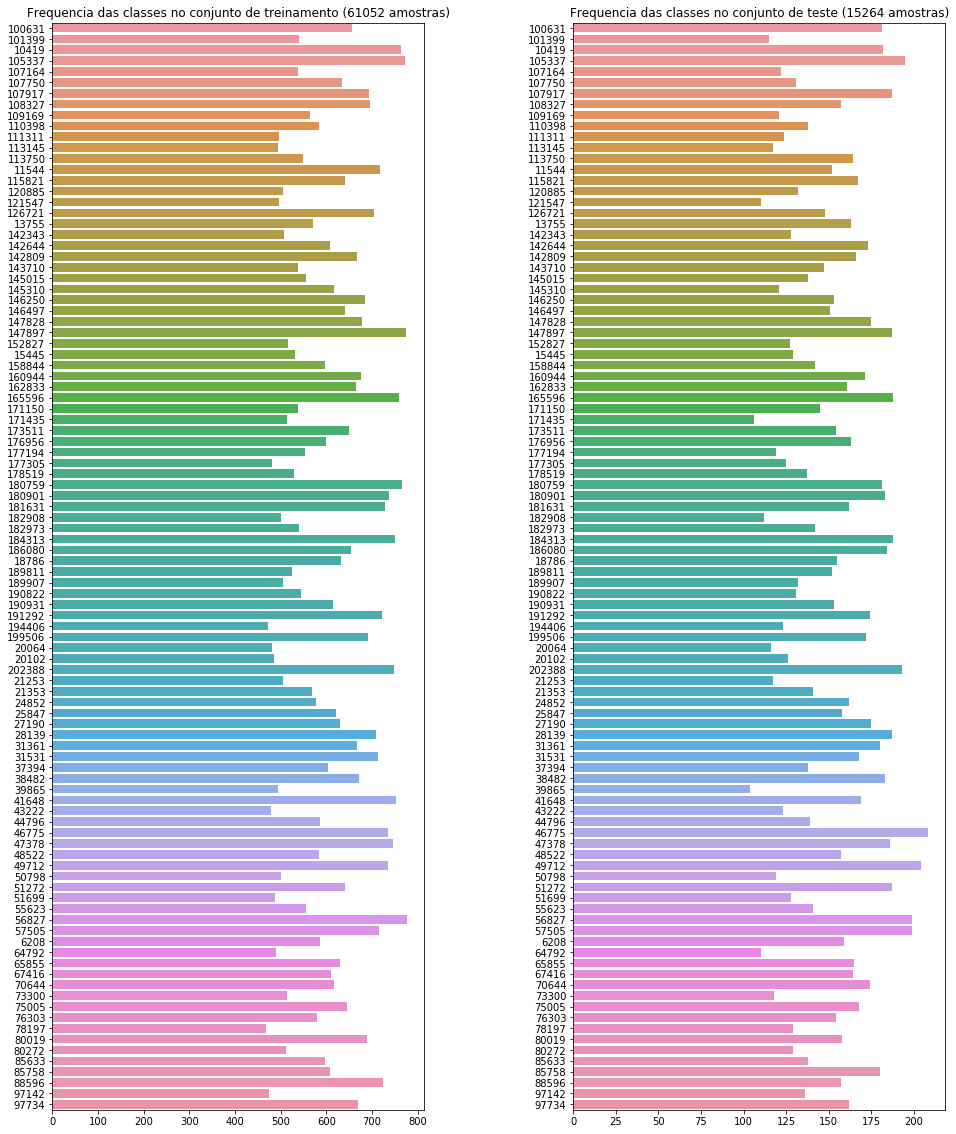

In [7]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(sample_generator.labels))
_, counts = np.unique(sample_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(sample_test_generator.labels))
_, counts = np.unique(sample_test_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

# Preprocessamento das imagens de treino e validação

##Utilizaremos 20% da base de treinamento para validação

In [8]:
train_batch_size = 64
val_batch_size = 64 

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/train",
                                                    target_size = target_size,
                                                    batch_size = train_batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/train",
                                                         target_size = target_size,
                                                         batch_size = val_batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

Found 48878 images belonging to 100 classes.
Found 12174 images belonging to 100 classes.


# Parâmetros para treinamento e validação

In [18]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

opt = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

basic_model = ResNet50(input_shape = input_shape,
                 weights = "imagenet",
                 include_top=False)

preprocess_input_model = preprocess_input

networkName = 'ResNet50-Tuning-All'

device = '/gpu:0'

epochs = 8
G = 8

train_steps = train_generator.samples // train_batch_size

validation_steps = validation_generator.samples // val_batch_size

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


# Funções de auxílio

In [22]:
from keras.utils.training_utils import multi_gpu_model

def model(base_model, name):

    # get layers and add average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D(name = 'global_mdc')(x)

    # add fully-connected layer
    x = Dense(512, activation='relu', name = 'dense_mdc')(x)

    # add output layer
    predictions = Dense(total_classes, activation='softmax', name = 'saida_mdc')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze pre-trained model area's layer
    for layer in base_model.layers:
        layer.trainable = False
    layer_num = utils.find_layer_idx(model, 'dense_mdc')
    
    model = multi_gpu_model(model, gpus=G)
    # update the weight that are added
    print('============== update weight that ared added ==============')
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    with tf.device(device):
      model.fit_generator(generator = train_generator,
                          steps_per_epoch = train_steps,
                          epochs = epochs // 4,
                          verbose = 1,
                          validation_data = validation_generator,
                          validation_steps = validation_steps,
                          callbacks = [callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         verbose=1)])

    # choose the layers which are updated by training
    for layer in model.layers:
        layer.trainable = True

    # update the weights

    print('============== fine tunning weights ==============')
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    with tf.device(device):
      history = model.fit_generator(generator = train_generator,
                                    steps_per_epoch = train_steps,
                                    epochs = epochs,
                                    verbose = 1,
                                    validation_data = validation_generator,
                                    validation_steps = validation_steps,
                                    callbacks = [callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         verbose= 1)])
                    
    return history, model

In [11]:
def learning_curve_model(history):

  plt.figure(figsize=(16, 6))
  
  plt.subplot(121)  
  plt.plot(history.history['acc'])  
  plt.plot(history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
   
  # summarize history for loss  
   
  plt.subplot(122)  
  plt.plot(history.history['loss'])  
  plt.plot(history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
  plt.show()

In [12]:
def evaluate_generator_model(model, name, generator=validation_generator, steps=validation_steps):
  generator.reset()
  score_val = model.evaluate_generator(generator = generator, steps = steps)
  print('[' + name +'] loss:', score_val[0])
  print('[' + name +'] accuracy (NOT BALANCED):', score_val[1])
  return score_val

In [13]:
def predict_generator_model(model, generator = validation_generator, steps = validation_steps):
  generator.reset()

  y_val_final = []
  prediction_final = []
  for i in range(1, generator.samples // steps + 1):
    x_val, y_val = generator.next()
    probabilities = model.predict(x_val)

    prediction_final =  np.append(prediction_final, np.argmax(probabilities, axis=1))  
    y_val_final = np.append(y_val_final, np.argmax(y_val, axis=1))
    
  return y_val_final, prediction_final

In [14]:
def classification_report_model(y_val_final, prediction_final, labels=classes):
  print(metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= False))

  return metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= True)

In [15]:
def confusion_matrix_model(y_test, predictions, labels=classes):
  c = metrics.confusion_matrix(y_test, predictions)
  r = c / c.sum(axis=1).reshape(-1, 1)

  plt.figure(figsize=(18, 14))
  ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', xticklabels=labels, yticklabels=labels);
  plt.show()
  
  showing = 10

  ordered_by_scores = np.argsort(np.diag(r))
  labels_sorted_by_score = np.asarray(labels)[ordered_by_scores]

  print('\nClasses incorretamente classificadas pelo modelo, com maior frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[:showing],
                                          np.diag(r)[ordered_by_scores])))

  print('\nClasses incorretamente classificadas pelo modelo, com menor frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[::-1][:showing],
                                          np.diag(r)[ordered_by_scores[::-1]])))
  return r

In [16]:
def evaluate_model(model, name, generator = validation_generator, steps = validation_steps):
  print('*** Prediction model - Part (1/4)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/4)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/4)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/4)****')
  evaluate_generator_model(model, name + '_val', generator, steps)
  evaluate_generator_model(model, name + '_train', train_generator, train_steps)

# ResNet50- Transfer Learning

## Fine Tuning

### Definindo a rede and training

In [ ]:
history, tunning_model = model(basic_model, networkName)
tunning_model.save('./final.model.' + networkName + '.h5')

with open('final.history.' + networkName + '.json', 'w') as f:
    json.dump(hist.history, f)

============== update weight that ared added ==============
Epoch 1/2
763/763 [==============================] - 566s 741ms/step - loss: 2.6081 - val_loss: 6.4798

Epoch 00001: val_loss improved from inf to 6.47984, saving model to ./ResNet50-Tuning-All.weights.h5
Epoch 2/2
763/763 [==============================] - 507s 664ms/step - loss: 1.9163 - val_loss: 7.8825

Epoch 00002: val_loss did not improve from 6.47984
============== fine tunning weights ==============
Epoch 1/8
763/763 [==============================] - 563s 738ms/step - loss: 1.4675 - acc: 0.6182 - val_loss: 8.2969 - val_acc: 0.0078

Epoch 00001: val_loss improved from inf to 8.29687, saving model to ./ResNet50-Tuning-All.weights.h5
Epoch 2/8
763/763 [==============================] - 509s 667ms/step - loss: 1.3524 - acc: 0.6450 - val_loss: 8.7596 - val_acc: 0.0053

Epoch 00002: val_loss did not improve from 8.29687
Epoch 3/8
763/763 [==============================] - 510s 668ms/step - loss: 1.2851 - acc: 0.6629 - val_l

TypeError: can't pickle module objects

In [ ]:
learning_curve_model(history)

## Evaluating model

In [ ]:
evaluate_model(tunning_model, networkName) 

## Check error

In [ ]:
validation_generator.reset()

x_sample, y_sample = validation_generator.next()
print('shape sample:', x_sample.shape)
print('label:', np.argmax(y_sample[0], axis=-1) )
plt.imshow(x_sample[0])
plt.show()

y_pred = tunning_model.predict(x_sample)
class_idxs_sorted = np.argsort(y_pred[0].flatten())[::-1]
topNclass = 5
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.4f}"
          .format(i + 1, classes[idx], idx, y_pred[0,idx]))

In [ ]:
# gradient weighted class activation map (Grad-CAM)
layer_idx = utils.find_layer_idx(tunning_model, 'saida_mdc')
final_conv_layer = utils.find_layer_idx(tunning_model, 'res5c_branch2c')

In [ ]:
# swap softmax with linear
tunning_model.layers[layer_idx].activation = activations.linear
model_mod = utils.apply_modifications(tunning_model)

In [ ]:
class_idx  = class_idxs_sorted[0]
seed_input = x_sample[0]

grad_top1  = visualize_cam(model_mod, 
                           layer_idx, 
                           class_idx, 
                           seed_input, 
                           penultimate_layer_idx = final_conv_layer,
                           backprop_modifier = None,
                           grad_modifier = None)

fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(seed_input)
axes[1].imshow(seed_input)
i = axes[1].imshow(grad_top1,cmap="jet",alpha=0.5)
fig.colorbar(i)
fig.suptitle("Pr(class={}) = {:5.2f}".format(
                      classes[class_idx],
                      y_pred[0,class_idx]))

In [ ]:
def plot_map(orignal, grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(orignal)
    axes[1].imshow(orignal)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.5)
    fig.colorbar(i)
    fig.suptitle("Pr(class={}) = {:5.2f}".format(
                      classes[class_idx],
                      y_pred[0,class_idx]))

In [ ]:
for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model_mod,
                           layer_idx,
                           class_idx, 
                           seed_input,
                           penultimate_layer_idx = final_conv_layer,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(seed_input, grads)